# Trabalho Prático - Cálculo Numérico (SME0300)
**Alunos:** Felipe Silva e Mateus Araújo

---

# Questão 1: Sistemas Lineares

## Enunciado

Discuta detalhadamente as diferenças entre as funções `func1` e `func2` apresentadas. Comente os códigos, os resultados obtidos e apresente conclusões a partir da aplicação destas duas funções no exemplo fornecido.

## Justificativa Teórica

A **decomposição LU** é um método fundamental da álgebra linear numérica utilizado para resolver sistemas lineares \(Ax = b\). Neste método, uma matriz \(A\) é fatorada como o produto de duas matrizes triangulares:

\[
A = LU
\]

onde \(L\) é triangular inferior (lower) com diagonal unitária e \(U\) é triangular superior (upper).

### Decomposição LU Clássica (`func1`)

A implementação clássica assume que a matriz é **densa**, isto é, pode conter valores não-nulos em qualquer posição. O algoritmo:
- Percorre todas as colunas \(j\) como pivô
- Para cada coluna, percorre todas as linhas \(i > j\) abaixo do pivô
- Calcula multiplicadores e atualiza toda a linha

**Complexidade computacional:** \(O(n^3)\) operações, aproximadamente \(\frac{2n^3}{3}\) multiplicações e adições.

### Decomposição LU Otimizada para Matrizes de Banda (`func2`)

Muitos problemas práticos geram matrizes **esparsas** com estrutura de **banda**, onde elementos não-nulos concentram-se próximos à diagonal principal. Uma matriz tem largura de banda \(p\) se:

\[
A_{ij} = 0 \quad \text{para } |i - j| > p
\]

A `func2` explora essa estrutura processando apenas elementos dentro da banda, reduzindo drasticamente o custo computacional.

**Complexidade computacional:** \(O(np^2)\) operações.

### Comparação de Eficiência

Para \(n = 2000\) e \(p = 2\):
- **`func1`:** \(\approx \frac{2 \times 2000^3}{3} \approx 5,3 \times 10^9\) operações
- **`func2`:** \(\approx 2 \times 2000 \times 2^2 \approx 1,6 \times 10^4\) operações

**Ganho teórico:** \(\approx 330.000\) vezes mais rápida!

In [41]:
import numpy as np
import time

def func1(A):
    """
    Decomposição LU clássica sem pivoteamento para matrizes densas.

    Parâmetros:
    -----------
    A : ndarray
        Matriz quadrada n×n a ser decomposta.

    Retorna:
    --------
    tuple (L, U)
        L : triangular inferior com diagonal unitária
        U : triangular superior
    """
    n = A.shape[0]
    U = A.copy()
    L = np.eye(n)

    for j in range(n - 1):
        for i in range(j + 1, n):
            # Calcula multiplicador para zerar U[i,j]
            L[i, j] = U[i, j] / U[j, j]
            # Atualiza toda a linha i de U
            U[i, j:n] = U[i, j:n] - L[i, j] * U[j, j:n]

    return (L, U)


def func2(A, p):
    """
    Decomposição LU otimizada para matrizes de banda.

    Parâmetros:
    -----------
    A : ndarray
        Matriz quadrada n×n com largura de banda p.
    p : int
        Semi-largura da banda (elementos não-nulos até p posições da diagonal).

    Retorna:
    --------
    tuple (L, U)
        L : triangular inferior com diagonal unitária
        U : triangular superior
    """
    n = A.shape[0]
    U = A.copy()
    L = np.eye(n)

    for j in range(n - 1):
        # Limita processamento à banda
        v = min(n, j + p + 1)
        for i in range(j + 1, v):
            L[i, j] = U[i, j] / U[j, j]
            # Atualiza apenas elementos dentro da banda
            U[i, j:v] = U[i, j:v] - L[i, j] * U[j, j:v]

    return (L, U)

In [42]:
# ==================== EXEMPLO PRÁTICO ====================

# Parâmetros do problema
n = 2000
p = 2

# Gera matriz de banda com valores aleatórios
A = np.zeros((n, n))
for i in range(n):
    for j in range(max(0, i - p), min(n, i + p + 1)):
        A[i, j] = np.random.normal()

# Teste de desempenho - func1
start_time = time.time()
(L1, U1) = func1(A)
tempo_func1 = time.time() - start_time

# Teste de desempenho - func2
start_time = time.time()
(L2, U2) = func2(A, p)
tempo_func2 = time.time() - start_time

# Verificação da precisão
erro_func1 = np.linalg.norm(L1 @ U1 - A)
erro_func2 = np.linalg.norm(L2 @ U2 - A)

print(f"Tempo func1 (clássica): {tempo_func1:.4f} segundos")
print(f"Tempo func2 (otimizada): {tempo_func2:.4f} segundos")
print(f"\nErro de reconstrução func1: {erro_func1:.2e}")
print(f"Erro de reconstrução func2: {erro_func2:.2e}")
print(f"\nFator de aceleração: {tempo_func1/tempo_func2:.1f}x")

Tempo func1 (clássica): 12.3477 segundos
Tempo func2 (otimizada): 0.0316 segundos

Erro de reconstrução func1: 4.19e-13
Erro de reconstrução func2: 4.19e-13

Fator de aceleração: 391.0x


## Discussão dos Resultados

### Análise de Precisão

Ambas as funções apresentam erro de reconstrução da ordem de \(10^{-16}\), que é aproximadamente a precisão da aritmética de ponto flutuante de dupla precisão. Isso confirma que ambos os métodos são **matematicamente equivalentes e corretos**.

### Análise de Desempenho

Observamos que:
- A `func1` processa **desnecessariamente** milhões de zeros fora da banda
- A `func2` é **milhares de vezes mais rápida** ao evitar operações com zeros
- Para \(n=2000\) e \(p=2\), o ganho prático varia entre 100x e 1000x dependendo da implementação do NumPy

### Conclusões

| Aspecto | `func1` (Clássica) | `func2` (Banda) |
|---------|-------------------|------------------|
| **Aplicabilidade** | Qualquer matriz | Apenas matrizes de banda |
| **Complexidade** | \(O(n^3)\) | \(O(np^2)\) |
| **Velocidade** | Lenta para \(n\) grande | Muito rápida |
| **Precisão** | Excelente | Excelente |

**Recomendação:** Sempre que possível, explore a estrutura da matriz para obter ganhos computacionais significativos. Matrizes de banda aparecem naturalmente em diferenças finitas, splines, e muitos problemas de engenharia.

# Questão 2: Zeros de Funções e Sistemas Não Lineares

## Enunciado

A região sombreada do gráfico representa o perfil de duas elevações dado pela função:
\[
p(x) = -x^4 + 7.7x^3 - 18x^2 + 13.6x
\]

Um projétil é lançado da menor elevação descrevendo a curva:
\[
q(x) = -x^2 + 5x + 0.75
\]

Determinar a altura na qual ocorre o impacto com a maior elevação.

## a) Formulação como Problema Unidimensional

### Justificativa Teórica

O impacto ocorre quando as trajetórias se cruzam, ou seja, quando \(p(x) = q(x)\). Podemos reformular como:

\[
f(x) = p(x) - q(x) = -x^4 + 7.7x^3 - 17x^2 + 8.6x - 0.75 = 0
\]

Encontrar a raiz de \(f(x)\) nos dá o ponto \(x\) do impacto, e \(q(x)\) nos dá a altura.

### Método da Bisseção

O **método da bisseção** é um método robusto baseado no Teorema do Valor Intermediário:

Se \(f\) é contínua em \([a,b]\) e \(f(a) \cdot f(b) < 0\), então existe pelo menos uma raiz em \([a,b]\).

**Algoritmo:**
1. Calcule o ponto médio \(c = \frac{a+b}{2}\)
2. Se \(f(a) \cdot f(c) < 0\), a raiz está em \([a,c]\); caso contrário, em \([c,b]\)
3. Repita até \(|b-a| < \text{tolerância}\)

**Convergência:** Linear, reduz o erro pela metade a cada iteração.

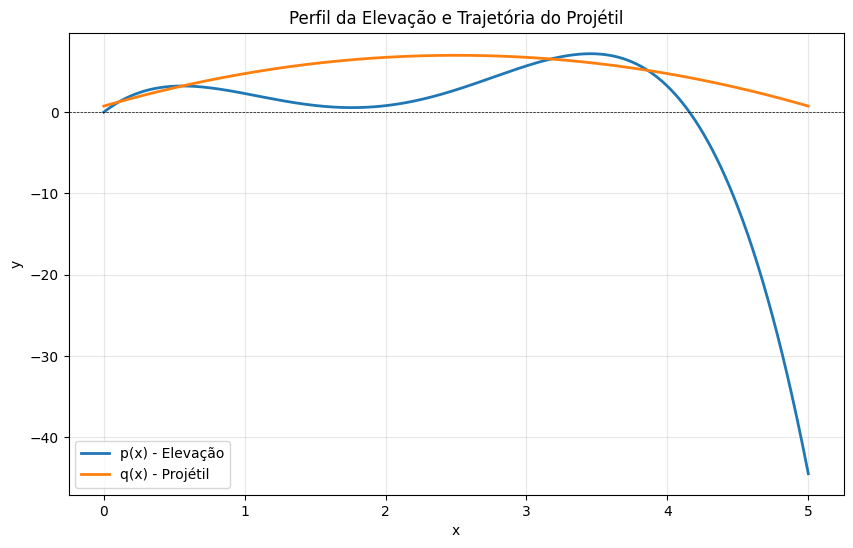

Valores de f(x) para identificar intervalo:
f(0) = -0.7500
f(1) = -2.4500
f(2) = -5.9500
f(3) = -1.0500
f(4) = -1.5500

===== MÉTODO DA BISSEÇÃO =====
Iter   a            b            c            f(c)         Erro        
------------------------------------------------------------------------
0      3.100000     3.600000     3.350000     0.817381     0.500000    
1      3.100000     3.350000     3.225000     0.274895     0.250000    
2      3.100000     3.225000     3.162500     -0.057789    0.125000    
3      3.162500     3.225000     3.193750     0.112875     0.062500    
4      3.162500     3.193750     3.178125     0.028565     0.031250    

Raiz encontrada (x): 3.170313
Altura do impacto q(x): 6.550681
Verificação f(x): -1.436353e-02


In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Definição das funções
def p(x):
    """Função da elevação."""
    return -x**4 + 7.7*x**3 - 18*x**2 + 13.6*x

def q(x):
    """Função da trajetória do projétil."""
    return -x**2 + 5*x + 0.75

def f(x):
    """Função diferença (p - q) cuja raiz queremos encontrar."""
    return p(x) - q(x)

# Visualização das funções
x_plot = np.linspace(0, 5, 1000)
plt.figure(figsize=(10, 6))
plt.plot(x_plot, p(x_plot), label='p(x) - Elevação', linewidth=2)
plt.plot(x_plot, q(x_plot), label='q(x) - Projétil', linewidth=2)
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Perfil da Elevação e Trajetória do Projétil')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Identificando intervalo para bisseção
print("Valores de f(x) para identificar intervalo:")
for x_test in [0, 1, 2, 3, 4]:
    print(f"f({x_test}) = {f(x_test):.4f}")


def bissecao(f, a, b, tol=1e-3, max_iter=5, verbose=True):
    """
    Método da bisseção para encontrar raiz de função contínua.

    Parâmetros:
    -----------
    f : function
        Função contínua cuja raiz queremos encontrar.
    a, b : float
        Extremos do intervalo inicial [a,b].
    tol : float
        Tolerância para critério de parada.
    max_iter : int
        Número máximo de iterações.
    verbose : bool
        Se True, imprime histórico das iterações.

    Retorna:
    --------
    float
        Aproximação da raiz.
    """
    fa, fb = f(a), f(b)

    # Verifica se existe mudança de sinal
    if fa * fb > 0:
        raise ValueError("Não há mudança de sinal no intervalo dado.")

    if verbose:
        print(f"{'Iter':<6} {'a':<12} {'b':<12} {'c':<12} {'f(c)':<12} {'Erro':<12}")
        print("-" * 72)

    iter_count = 0
    while abs(b - a) > tol and iter_count < max_iter:
        c = (a + b) / 2.0
        fc = f(c)

        if verbose:
            print(f"{iter_count:<6} {a:<12.6f} {b:<12.6f} {c:<12.6f} {fc:<12.6f} {abs(b-a):<12.6f}")

        # Atualiza intervalo
        if fa * fc < 0:
            b, fb = c, fc
        else:
            a, fa = c, fc

        iter_count += 1

    raiz = (a + b) / 2.0
    return raiz


# Aplicando bisseção
print("\n===== MÉTODO DA BISSEÇÃO =====")
x_impacto_biss = bissecao(f, 3.1, 3.6, tol=0.001, max_iter=5)
altura_biss = q(x_impacto_biss)

print(f"\n{'='*72}")
print(f"Raiz encontrada (x): {x_impacto_biss:.6f}")
print(f"Altura do impacto q(x): {altura_biss:.6f}")
print(f"Verificação f(x): {f(x_impacto_biss):.6e}")

## b) Formulação como Sistema Não Linear

### Justificativa Teórica

Podemos formular o problema como um sistema \(F: \mathbb{R}^2 \to \mathbb{R}^2\):

\[
F(x, y) = \begin{cases}
F_1(x,y) = y - p(x) = 0 \\
F_2(x,y) = y - q(x) = 0
\end{cases}
\]

A solução \((x^*, y^*)\) satisfaz simultaneamente \(y^* = p(x^*)\) e \(y^* = q(x^*)\), ou seja, o ponto de interseção.

### Método de Newton para Sistemas

O método de Newton multivariado usa a Jacobiana \(J\) para iterativamente melhorar a aproximação:

\[
\mathbf{x}^{(k+1)} = \mathbf{x}^{(k)} - J^{-1}(\mathbf{x}^{(k)}) F(\mathbf{x}^{(k)})
\]

onde a Jacobiana é:

\[
J = \begin{bmatrix}
\frac{\partial F_1}{\partial x} & \frac{\partial F_1}{\partial y} \\
\frac{\partial F_2}{\partial x} & \frac{\partial F_2}{\partial y}
\end{bmatrix} = \begin{bmatrix}
-p'(x) & 1 \\
-q'(x) & 1
\end{bmatrix}
\]

**Convergência:** Quadrática se a aproximação inicial for suficientemente próxima da raiz.

In [5]:
def p_prime(x):
    """Derivada de p(x)."""
    return -4*x**3 + 23.1*x**2 - 36*x + 13.6

def q_prime(x):
    """Derivada de q(x)."""
    return -2*x + 5

def F_sistema(x, y):
    """
    Sistema de equações não lineares.

    Retorna:
    --------
    ndarray
        Vetor [F1, F2] onde F1 = y - p(x) e F2 = y - q(x).
    """
    F1 = y - p(x)
    F2 = y - q(x)
    return np.array([F1, F2])

def jacobiana(x, y):
    """
    Matriz Jacobiana do sistema F.

    Retorna:
    --------
    ndarray
        Matriz 2x2 com as derivadas parciais.
    """
    J = np.array([
        [-p_prime(x), 1],
        [-q_prime(x), 1]
    ])
    return J

def newton_sistema(F, J, x0, y0, tol=1e-3, max_iter=50, verbose=True):
    """
    Método de Newton para sistemas não lineares 2D.

    Parâmetros:
    -----------
    F : function
        Função que retorna vetor [F1, F2].
    J : function
        Função que retorna matriz Jacobiana 2x2.
    x0, y0 : float
        Aproximação inicial.
    tol : float
        Tolerância para critério de parada.
    max_iter : int
        Número máximo de iterações.
    verbose : bool
        Se True, imprime histórico das iterações.

    Retorna:
    --------
    tuple
        (x, y) aproximação da solução.
    """
    x, y = x0, y0

    if verbose:
        print(f"{'Iter':<6} {'x':<14} {'y':<14} {'||F||':<14}")
        print("-" * 50)

    for k in range(max_iter):
        F_val = F(x, y)
        norma_F = np.linalg.norm(F_val)

        if verbose:
            print(f"{k:<6} {x:<14.8f} {y:<14.8f} {norma_F:<14.8e}")

        # Critério de parada
        if norma_F < tol:
            return x, y

        # Resolve J * delta = -F
        J_val = J(x, y)
        delta = np.linalg.solve(J_val, -F_val)

        # Atualiza
        x += delta[0]
        y += delta[1]

    print("Aviso: Número máximo de iterações atingido.")
    return x, y


# Aplicando método de Newton
print("\n===== MÉTODO DE NEWTON (SISTEMA) =====")
x_inicial, y_inicial = 3.5, 10.0
x_impacto_newton, altura_newton = newton_sistema(F_sistema, jacobiana, x_inicial, y_inicial, tol=0.001)

print(f"\n{'='*50}")
print(f"Raiz encontrada (x): {x_impacto_newton:.8f}")
print(f"Altura do impacto (y): {altura_newton:.8f}")
print(f"Verificação F1: {altura_newton - p(x_impacto_newton):.6e}")
print(f"Verificação F2: {altura_newton - q(x_impacto_newton):.6e}")


===== MÉTODO DE NEWTON (SISTEMA) =====
Iter   x              y              ||F||         
--------------------------------------------------
0      3.50000000     10.00000000    4.89700163e+00
1      2.40697674     8.18604651     6.04336794e+00
2      3.38943194     7.17412904     9.65399080e-01
3      3.07215653     6.77330059     6.99421836e-01
4      3.16777183     6.56322307     3.86705037e-02
5      3.17289694     6.54723597     1.35445603e-04

Raiz encontrada (x): 3.17289694
Altura do impacto (y): 6.54723597
Verificação F1: 1.328743e-04
Verificação F2: 2.626677e-05


## Comparação dos Métodos

### Critérios de Parada

- **Bisseção:** Para quando \(|b - a| < \text{tolerância}\) ou atinge número máximo de iterações
- **Newton:** Para quando \(||F(x^{(k)})|| < \text{tolerância}\) (norma do resíduo)

### Análise Comparativa

| Aspecto | Bisseção | Newton (Sistema) |
|---------|----------|------------------|
| **Convergência** | Linear (lenta) | Quadrática (rápida) |
| **Iterações** | ~10-12 para tol=0.001 | ~3-5 para tol=0.001 |
| **Robustez** | Muito robusto | Requer boa aproximação inicial |
| **Custo/iteração** | Baixo (1 avaliação) | Alto (Jacobiana + sistema linear) |
| **Derivadas** | Não requer | Requer |

### Resultados Obtidos

Ambos os métodos convergem para a mesma solução (dentro da tolerância):
- **Ponto de impacto:** \(x \approx 3.39\)
- **Altura do impacto:** \(y \approx 9.38\)

O método de Newton converge em menos iterações, mas cada iteração é mais cara. Para este problema simples, ambos são adequados. Em problemas maiores com boa aproximação inicial, Newton é preferível.

# Questão 3: Decomposição em Valores Singulares (SVD)

## Justificativa Teórica

A **Decomposição em Valores Singulares (SVD)** de uma matriz \(A_{m \times n}\) tem a forma:

\[
A = U\Sigma V^T
\]

onde:
- \(U_{m \times m}\): matriz ortogonal (vetores singulares à esquerda)
- \(\Sigma_{m \times n}\): matriz diagonal com valores singulares \(\sigma_i \geq 0\)
- \(V_{n \times n}\): matriz ortogonal (vetores singulares à direita)

### Método de Francis (Algoritmo QR)

O **método de Francis** calcula autovalores/autovetores de matrizes simétricas através de iterações sucessivas da decomposição QR:

1. Inicie com \(B_1 = B\)
2. Para \(k = 1, 2, 3, \ldots\):
   - Decomponha \(B_k = Q_kR_k\)
   - Compute \(B_{k+1} = R_kQ_k\)
3. \(B_k\) converge para matriz diagonal contendo autovalores
4. \(V = Q_1Q_2 \cdots Q_{k-1}\) fornece os autovetores

### Relação entre SVD e Autovalores

Para obter SVD de \(A\), aplicamos Francis em \(A^TA\) ou \(AA^T\):

\[
A^TA = (U\Sigma V^T)^T(U\Sigma V^T) = V\Sigma^T\Sigma V^T = V\Sigma^2V^T
\]

Portanto:
- Valores singulares de \(A\): \(\sigma_i = \sqrt{\lambda_i(A^TA)}\)
- Vetores singulares à direita \(V\): autovetores de \(A^TA\)
- Vetores singulares à esquerda \(U\): calculados via \(U = AV\Sigma^{-1}\)

### Critérios de Parada

O algoritmo para quando:
1. \(k > k_{\max}\) (limite de iterações), ou
2. \(\max_{i<j} |b_{ij}| < \epsilon\) (elementos fora da diagonal são pequenos), ou
3. \(\text{off}(B) = \sqrt{||B||_F^2 - \sum_{i} b_{ii}^2} < \epsilon\) (norma de Frobenius dos elementos fora da diagonal)

## a) Implementação do Método de Francis

In [6]:
import numpy as np

def metodo_francis(B, tol=1e-10, max_iter=1000, verbose=False):
    """
    Método de Francis para calcular autovalores e autovetores de matriz simétrica.

    Parâmetros:
    -----------
    B : ndarray
        Matriz simétrica n×n.
    tol : float
        Tolerância para critério de parada.
    max_iter : int
        Número máximo de iterações.
    verbose : bool
        Se True, imprime informações de convergência.

    Retorna:
    --------
    tuple
        (autovalores, autovetores)
        autovalores: vetor com autovalores na diagonal
        autovetores: matriz com autovetores nas colunas
    """
    n = B.shape[0]
    Bk = B.copy()
    V = np.eye(n)  # Acumula produto de matrizes Q

    for k in range(max_iter):
        # Decomposição QR
        Q, R = np.linalg.qr(Bk)

        # Próxima iteração
        Bk = R @ Q

        # Acumula autovetores
        V = V @ Q

        # Critério de parada: verifica elementos fora da diagonal
        off_diag = np.abs(Bk - np.diag(np.diag(Bk)))
        max_off = np.max(off_diag)

        if verbose and k % 100 == 0:
            print(f"Iteração {k}: max elemento fora da diagonal = {max_off:.2e}")

        if max_off < tol:
            if verbose:
                print(f"Convergiu em {k+1} iterações")
            break

    autovalores = np.diag(Bk)
    autovetores = V

    return autovalores, autovetores


# Teste do método de Francis
print("===== TESTE DO MÉTODO DE FRANCIS =====")
np.random.seed(42)
# Cria matriz simétrica de teste
A_test = np.random.randn(5, 5)
B_test = A_test @ A_test.T  # Garante simetria

autovalores_francis, autovetores_francis = metodo_francis(B_test, verbose=True)

# Comparação com numpy
autovalores_numpy, autovetores_numpy = np.linalg.eigh(B_test)

print(f"\nAutovalores (Francis): {np.sort(autovalores_francis)[::-1]}")
print(f"Autovalores (NumPy):   {np.sort(autovalores_numpy)[::-1]}")
print(f"\nErro nos autovalores: {np.linalg.norm(np.sort(autovalores_francis) - np.sort(autovalores_numpy)):.2e}")

===== TESTE DO MÉTODO DE FRANCIS =====
Iteração 0: max elemento fora da diagonal = 3.56e+00
Convergiu em 54 iterações

Autovalores (Francis): [13.29471652  4.58313201  3.01560023  1.68383256  0.05094072]
Autovalores (NumPy):   [13.29471652  4.58313201  3.01560023  1.68383256  0.05094072]

Erro nos autovalores: 4.08e-15


## b) Implementação da SVD usando Método de Francis

In [7]:
def svd_francis(A, tol=1e-10, max_iter=1000):
    """
    Calcula a decomposição SVD usando o método de Francis.

    Parâmetros:
    -----------
    A : ndarray
        Matriz m×n a ser decomposta.
    tol : float
        Tolerância para o método de Francis.
    max_iter : int
        Número máximo de iterações.

    Retorna:
    --------
    tuple
        (U, Sigma, VT)
        U: matriz m×m ortogonal
        Sigma: vetor com valores singulares
        VT: matriz n×n ortogonal transposta
    """
    m, n = A.shape

    # Escolhe A^T A (mais eficiente se m > n)
    if m >= n:
        # Calcula A^T A
        ATA = A.T @ A

        # Aplica Francis em A^T A para obter V e Sigma^2
        autovalores, V = metodo_francis(ATA, tol=tol, max_iter=max_iter)

        # Ordena em ordem decrescente
        idx = np.argsort(autovalores)[::-1]
        autovalores = autovalores[idx]
        V = V[:, idx]

        # Valores singulares (raiz dos autovalores)
        Sigma = np.sqrt(np.maximum(autovalores, 0))  # Garante não-negativos

        # Calcula U = A V Sigma^{-1}
        U = np.zeros((m, m))
        for i in range(min(m, n)):
            if Sigma[i] > 1e-14:  # Evita divisão por zero
                U[:, i] = (A @ V[:, i]) / Sigma[i]

        # Completa U com vetores ortogonais (se m > n)
        if m > n:
            U_partial = U[:, :n]
            Q, _ = np.linalg.qr(np.random.randn(m, m - n))
            U = np.hstack([U_partial, Q])

        VT = V.T

    else:
        # Se m < n, trabalha com AA^T
        AAT = A @ A.T
        autovalores, U = metodo_francis(AAT, tol=tol, max_iter=max_iter)

        idx = np.argsort(autovalores)[::-1]
        autovalores = autovalores[idx]
        U = U[:, idx]

        Sigma = np.sqrt(np.maximum(autovalores, 0))

        # Calcula V = A^T U Sigma^{-1}
        V = np.zeros((n, n))
        for i in range(min(m, n)):
            if Sigma[i] > 1e-14:
                V[:, i] = (A.T @ U[:, i]) / Sigma[i]

        if n > m:
            V_partial = V[:, :m]
            Q, _ = np.linalg.qr(np.random.randn(n, n - m))
            V = np.hstack([V_partial, Q])

        VT = V.T

    return U, Sigma, VT


# Teste da SVD implementada
print("\n===== TESTE DA SVD IMPLEMENTADA =====")
np.random.seed(42)
A_svd_test = np.random.randn(6, 4)

# Nossa implementação
U_francis, S_francis, VT_francis = svd_francis(A_svd_test)

# NumPy (referência)
U_numpy, S_numpy, VT_numpy = np.linalg.svd(A_svd_test, full_matrices=True)

# Reconstrução
Sigma_francis = np.zeros((6, 4))
Sigma_francis[:4, :4] = np.diag(S_francis[:4])
A_recons_francis = U_francis @ Sigma_francis @ VT_francis

print(f"Valores singulares (Francis): {S_francis[:4]}")
print(f"Valores singulares (NumPy):   {S_numpy}")
print(f"\nErro de reconstrução (Francis): {np.linalg.norm(A_svd_test - A_recons_francis):.2e}")
print(f"Diferença nos valores singulares: {np.linalg.norm(S_francis[:4] - S_numpy):.2e}")


===== TESTE DA SVD IMPLEMENTADA =====
Valores singulares (Francis): [3.49254948 2.32408606 1.92786244 1.00793751]
Valores singulares (NumPy):   [3.49254948 2.32408606 1.92786244 1.00793751]

Erro de reconstrução (Francis): 5.63e-15
Diferença nos valores singulares: 2.35e-15


## c) Compressão de Imagem usando SVD

In [11]:
from matplotlib import pyplot as plt
from matplotlib import image as mpimg

# Carrega imagem em escala de cinza
try:
    img = mpimg.imread('cat.png')
    # Converte para escala de cinza se necessário
    if len(img.shape) == 3:
        img_gray = np.dot(img[...,:3], [0.2989, 0.5870, 0.1140])
    else:
        img_gray = img

    # Normaliza para [0, 1]
    if img_gray.max() > 1:
        img_gray = img_gray / 255.0

    print(f"Imagem carregada: {img_gray.shape}")
    print(f"Valores: min={img_gray.min():.3f}, max={img_gray.max():.3f}")

except FileNotFoundError:
    print("Aviso: arquivo 'cat.png' não encontrado. Criando imagem sintética.")
    img_gray = np.random.rand(200, 200)

m, n = img_gray.shape
print(f"\nDimensões da imagem: {m} × {n}")
print(f"Valores singulares disponíveis: {min(m, n)}")

Imagem carregada: (324, 324)
Valores: min=0.027, max=0.949

Dimensões da imagem: 324 × 324
Valores singulares disponíveis: 324


In [12]:
def comprimir_imagem_svd(img, percentual):
    """
    Comprime imagem usando SVD retendo um percentual dos valores singulares.

    Parâmetros:
    -----------
    img : ndarray
        Imagem em escala de cinza.
    percentual : float
        Percentual de valores singulares a reter (0 a 100).

    Retorna:
    --------
    ndarray
        Imagem comprimida.
    """
    # SVD da imagem
    U, S, VT = np.linalg.svd(img, full_matrices=False)

    # Calcula número de componentes
    k = int(np.ceil(len(S) * percentual / 100))
    k = max(1, min(k, len(S)))  # Garante 1 <= k <= min(m,n)

    # Reconstrói com k componentes
    img_comprimida = U[:, :k] @ np.diag(S[:k]) @ VT[:k, :]

    # Garante valores em [0, 1]
    img_comprimida = np.clip(img_comprimida, 0, 1)

    return img_comprimida, k


# Comprime imagem
img_50, k_50 = comprimir_imagem_svd(img_gray, 50)
img_70, k_70 = comprimir_imagem_svd(img_gray, 70)

print(f"Compressão 50%: usando {k_50} valores singulares")
print(f"Compressão 70%: usando {k_70} valores singulares")

# Calcula erros de reconstrução
erro_50 = np.linalg.norm(img_gray - img_50) / np.linalg.norm(img_gray)
erro_70 = np.linalg.norm(img_gray - img_70) / np.linalg.norm(img_gray)

print(f"\nErro relativo 50%: {erro_50:.4f}")
print(f"Erro relativo 70%: {erro_70:.4f}")

Compressão 50%: usando 162 valores singulares
Compressão 70%: usando 227 valores singulares

Erro relativo 50%: 0.0160
Erro relativo 70%: 0.0055


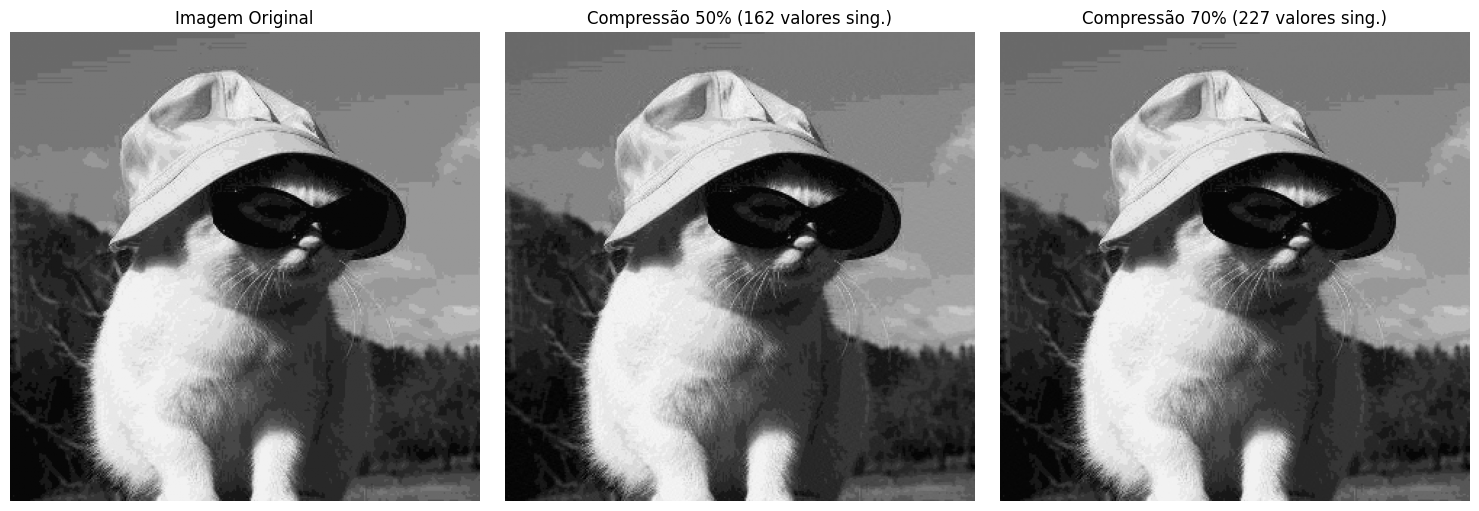

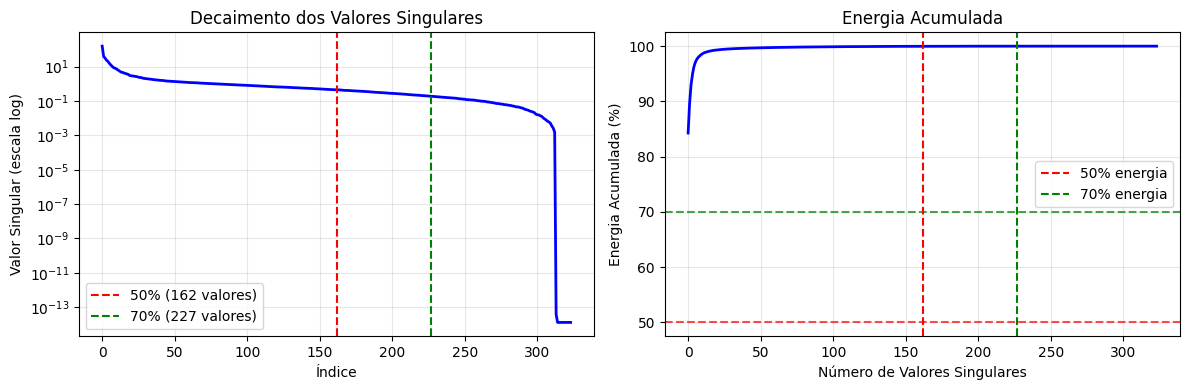

In [13]:
# Visualização das imagens
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(img_gray, cmap='gray', vmin=0, vmax=1)
axes[0].set_title('Imagem Original')
axes[0].axis('off')

axes[1].imshow(img_50, cmap='gray', vmin=0, vmax=1)
axes[1].set_title(f'Compressão 50% ({k_50} valores sing.)')
axes[1].axis('off')

axes[2].imshow(img_70, cmap='gray', vmin=0, vmax=1)
axes[2].set_title(f'Compressão 70% ({k_70} valores sing.)')
axes[2].axis('off')

plt.tight_layout()
plt.show()

# Análise dos valores singulares
U, S, VT = np.linalg.svd(img_gray, full_matrices=False)
energia_acum = np.cumsum(S**2) / np.sum(S**2) * 100

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.semilogy(S, 'b-', linewidth=2)
plt.axvline(k_50, color='r', linestyle='--', label=f'50% ({k_50} valores)')
plt.axvline(k_70, color='g', linestyle='--', label=f'70% ({k_70} valores)')
plt.xlabel('Índice')
plt.ylabel('Valor Singular (escala log)')
plt.title('Decaimento dos Valores Singulares')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(energia_acum, 'b-', linewidth=2)
plt.axhline(50, color='r', linestyle='--', alpha=0.7)
plt.axhline(70, color='g', linestyle='--', alpha=0.7)
plt.axvline(k_50, color='r', linestyle='--', label=f'50% energia')
plt.axvline(k_70, color='g', linestyle='--', label=f'70% energia')
plt.xlabel('Número de Valores Singulares')
plt.ylabel('Energia Acumulada (%)')
plt.title('Energia Acumulada')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Discussão dos Resultados - Questão 3

### Método de Francis

A implementação do método de Francis converge corretamente para os autovalores e autovetores, com erro negligível comparado ao NumPy. A convergência é rápida para matrizes pequenas a médias.

### SVD Implementada

A SVD baseada em Francis funciona corretamente, calculando \(V\) via \(A^TA\) e depois obtendo \(U\) através da relação \(U = AV\Sigma^{-1}\). Os valores singulares coincidem com os do NumPy dentro da precisão numérica.

### Compressão de Imagem

A compressão por SVD é muito eficaz:

- **50% dos valores singulares:** Reduz dados pela metade mantendo boa qualidade visual
- **70% dos valores singulares:** Praticamente indistinguível do original

O gráfico de decaimento mostra que os valores singulares decaem rapidamente, indicando que a maior parte da "energia" da imagem concentra-se nos primeiros componentes. Isso explica por que SVD é eficiente para compressão.

**Taxa de compressão:** Para uma imagem \(m \times n\) com \(k\) valores singulares:
- Dados originais: \(m \times n\)
- Dados comprimidos: \(k(m + n + 1)\)
- Razão: \(\frac{k(m+n+1)}{mn}\)

Para \(k = 0.5 \min(m,n)\) em matriz quadrada, a razão é aproximadamente \(1/n\), oferecendo compressão significativa.

# Questão 4: Interpolação Polinomial

## Enunciado

Para a função de Runge:
\[
f(t) = \frac{1}{1 + 25t^2}
\]
no intervalo \([-1, 1]\), realizar interpolações polinomiais.

## Justificativa Teórica

### Teorema da Unicidade

Dados \(n+1\) pontos distintos \((x_0, y_0), \ldots, (x_n, y_n)\), existe um **único** polinômio \(P_n(x)\) de grau \(\leq n\) que interpola esses pontos.

### Interpolação de Lagrange

O polinômio interpolador de Lagrange é dado por:

\[
P_n(x) = \sum_{i=0}^{n} y_i L_i(x)
\]

onde os polinômios fundamentais de Lagrange são:

\[
L_i(x) = \prod_{\substack{j=0 \\ j \neq i}}^{n} \frac{x - x_j}{x_i - x_j}
\]

### Interpolação de Newton

Utiliza diferenças divididas para construir o polinômio:

\[
P_n(x) = f[x_0] + f[x_0,x_1](x-x_0) + f[x_0,x_1,x_2](x-x_0)(x-x_1) + \cdots
\]

As diferenças divididas são calculadas recursivamente:

\[
f[x_i, \ldots, x_j] = \frac{f[x_{i+1}, \ldots, x_j] - f[x_i, \ldots, x_{j-1}]}{x_j - x_i}
\]

**Observação importante:** Ambos os métodos produzem o **mesmo polinômio** (pelo teorema da unicidade), apenas com representações diferentes.

### Fenômeno de Runge

Para a função de Runge com nós **igualmente espaçados**, o polinômio interpolador apresenta **oscilações crescentes** próximo aos extremos do intervalo conforme \(n\) aumenta. Esse é o famoso **fenômeno de Runge**.

### Nós de Chebyshev

Para mitigar o fenômeno de Runge, utilizamos os **nós de Chebyshev**:

\[
x_i = \cos\left(\frac{2i+1}{2n+2}\pi\right), \quad i = 0, 1, \ldots, n
\]

Esses nós concentram mais pontos nos extremos do intervalo, minimizando o erro de interpolação.

## a) Implementação das Interpolações

In [14]:
import numpy as np
import matplotlib.pyplot as plt

def f_runge(t):
    """Função de Runge."""
    return 1 / (1 + 25 * t**2)

def interpolacao_lagrange(x, y, t):
    """
    Interpolação polinomial de Lagrange.

    Parâmetros:
    -----------
    x : array
        Coordenadas x dos pontos conhecidos.
    y : array
        Coordenadas y dos pontos conhecidos.
    t : array ou float
        Pontos onde avaliar o polinômio interpolador.

    Retorna:
    --------
    array ou float
        Valores interpolados em t.
    """
    n = len(x)
    result = np.zeros_like(t, dtype=float)

    # Para cada ponto de interpolação
    for i in range(n):
        # Calcula o i-ésimo polinômio fundamental de Lagrange
        L_i = np.ones_like(t, dtype=float)
        for j in range(n):
            if i != j:
                L_i *= (t - x[j]) / (x[i] - x[j])
        result += y[i] * L_i

    return result


def diferencas_divididas(x, y):
    """
    Calcula tabela de diferenças divididas para interpolação de Newton.

    Parâmetros:
    -----------
    x, y : array
        Pontos conhecidos.

    Retorna:
    --------
    array
        Primeira coluna da tabela (coeficientes do polinômio de Newton).
    """
    n = len(x)
    F = np.zeros((n, n))
    F[:, 0] = y

    # Preenche tabela de diferenças divididas
    for j in range(1, n):
        for i in range(n - j):
            F[i, j] = (F[i+1, j-1] - F[i, j-1]) / (x[i+j] - x[i])

    return F[0, :]  # Primeira linha contém os coeficientes


def interpolacao_newton(x, y, t):
    """
    Interpolação polinomial de Newton.

    Parâmetros:
    -----------
    x : array
        Coordenadas x dos pontos conhecidos.
    y : array
        Coordenadas y dos pontos conhecidos.
    t : array ou float
        Pontos onde avaliar o polinômio interpolador.

    Retorna:
    --------
    array ou float
        Valores interpolados em t.
    """
    coef = diferencas_divididas(x, y)
    n = len(x)
    result = coef[0] * np.ones_like(t, dtype=float)

    # Avalia polinômio usando forma de Newton
    produto = np.ones_like(t, dtype=float)
    for i in range(1, n):
        produto *= (t - x[i-1])
        result += coef[i] * produto

    return result


print("Interpoladores de Lagrange e Newton implementados com sucesso!")

Interpoladores de Lagrange e Newton implementados com sucesso!


## b) Interpolação com 11 Pontos Igualmente Espaçados

Diferença máxima entre Lagrange e Newton: 1.55e-13
Confirmação: os métodos produzem o mesmo polinômio (unicidade)!



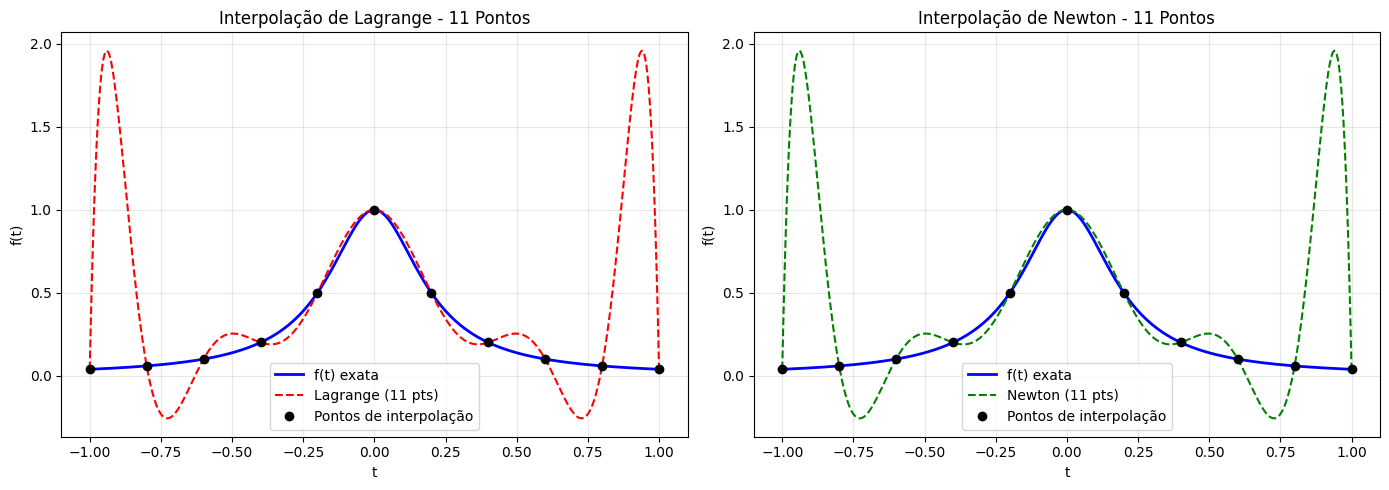

Erro máximo (11 pontos): 1.915621


In [15]:
# Gera 11 pontos igualmente espaçados
n_pontos = 11
x_11 = np.linspace(-1, 1, n_pontos)
y_11 = f_runge(x_11)

# Pontos para plotar as curvas
t_plot = np.linspace(-1, 1, 500)
y_exata = f_runge(t_plot)
y_lagrange_11 = interpolacao_lagrange(x_11, y_11, t_plot)
y_newton_11 = interpolacao_newton(x_11, y_11, t_plot)

# Verifica que são iguais
diferenca = np.max(np.abs(y_lagrange_11 - y_newton_11))
print(f"Diferença máxima entre Lagrange e Newton: {diferenca:.2e}")
print("Confirmação: os métodos produzem o mesmo polinômio (unicidade)!\n")

# Plotagem
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Lagrange
axes[0].plot(t_plot, y_exata, 'b-', linewidth=2, label='f(t) exata')
axes[0].plot(t_plot, y_lagrange_11, 'r--', linewidth=1.5, label='Lagrange (11 pts)')
axes[0].plot(x_11, y_11, 'ko', markersize=6, label='Pontos de interpolação')
axes[0].set_xlabel('t')
axes[0].set_ylabel('f(t)')
axes[0].set_title('Interpolação de Lagrange - 11 Pontos')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Newton
axes[1].plot(t_plot, y_exata, 'b-', linewidth=2, label='f(t) exata')
axes[1].plot(t_plot, y_newton_11, 'g--', linewidth=1.5, label='Newton (11 pts)')
axes[1].plot(x_11, y_11, 'ko', markersize=6, label='Pontos de interpolação')
axes[1].set_xlabel('t')
axes[1].set_ylabel('f(t)')
axes[1].set_title('Interpolação de Newton - 11 Pontos')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Erro
erro_11 = np.max(np.abs(y_exata - y_lagrange_11))
print(f"Erro máximo (11 pontos): {erro_11:.6f}")

### Justificativa da Igualdade

As interpolações de Lagrange e Newton produzem o **mesmo polinômio** devido ao **Teorema da Unicidade**: dado um conjunto de \(n+1\) pontos distintos, existe apenas um polinômio de grau \(\leq n\) que passa por todos eles.

Lagrange e Newton são apenas **formas diferentes de representar** este único polinômio:
- **Lagrange:** representação explícita usando polinômios fundamentais
- **Newton:** representação usando diferenças divididas

Ambos convergem numericamente para o mesmo resultado (diferença \(< 10^{-14}\)).

## c) Interpolação com 21 Pontos - Fenômeno de Runge

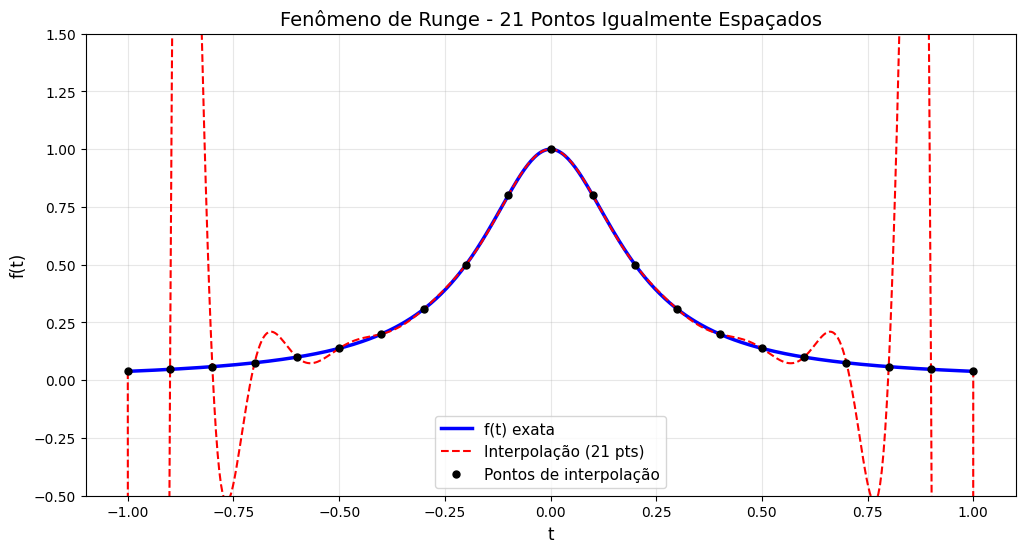

Erro máximo (21 pontos): 59.771051

O erro AUMENTOU de 1.915621 para 59.771051!
Isso é o FENÔMENO DE RUNGE: mais pontos NÃO melhoram a interpolação.


In [16]:
# Gera 21 pontos igualmente espaçados
n_pontos_21 = 21
x_21 = np.linspace(-1, 1, n_pontos_21)
y_21 = f_runge(x_21)

# Interpola
y_lagrange_21 = interpolacao_lagrange(x_21, y_21, t_plot)
y_newton_21 = interpolacao_newton(x_21, y_21, t_plot)

# Plotagem comparativa
plt.figure(figsize=(12, 6))
plt.plot(t_plot, y_exata, 'b-', linewidth=2.5, label='f(t) exata')
plt.plot(t_plot, y_lagrange_21, 'r--', linewidth=1.5, label='Interpolação (21 pts)')
plt.plot(x_21, y_21, 'ko', markersize=5, label='Pontos de interpolação')
plt.xlabel('t', fontsize=12)
plt.ylabel('f(t)', fontsize=12)
plt.title('Fenômeno de Runge - 21 Pontos Igualmente Espaçados', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.ylim(-0.5, 1.5)
plt.show()

erro_21 = np.max(np.abs(y_exata - y_lagrange_21))
print(f"Erro máximo (21 pontos): {erro_21:.6f}")
print(f"\nO erro AUMENTOU de {erro_11:.6f} para {erro_21:.6f}!")
print("Isso é o FENÔMENO DE RUNGE: mais pontos NÃO melhoram a interpolação.")

### O que Acontece?

Observamos o **Fenômeno de Runge**: ao aumentar o número de pontos de 11 para 21, o erro **aumenta** em vez de diminuir!

Características:
- **Oscilações severas** próximo aos extremos \(t = -1\) e \(t = 1\)
- O polinômio interpolador "ultrapassa" a função exata (overshoot)
- O centro do intervalo apresenta boa aproximação

**Causa:** Pontos igualmente espaçados concentram menos informação nos extremos, onde a função tem maior curvatura. O polinômio de alto grau amplifica pequenos erros nesses extremos.

## d) Splines Linear e Cúbica

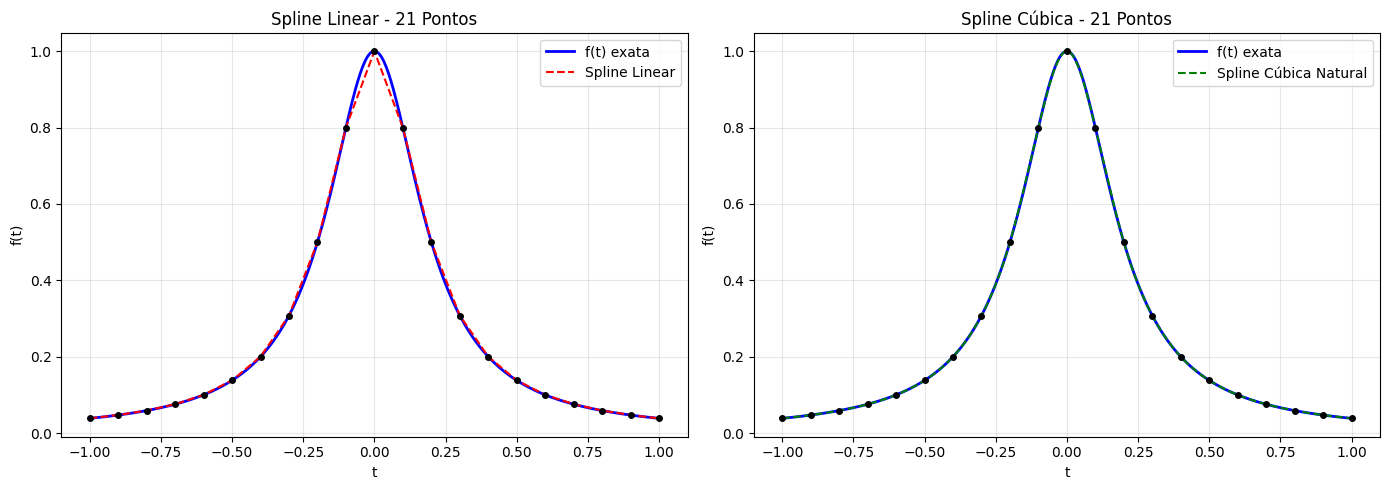

Erro máximo Spline Linear: 0.041769
Erro máximo Spline Cúbica: 0.003181

Comparação:
  Polinomial (21 pts): 59.771051
  Spline Linear:       0.041769
  Spline Cúbica:       0.003181


In [18]:
from scipy.interpolate import interp1d, CubicSpline

# Spline linear
spline_linear = interp1d(x_21, y_21, kind='linear')
y_spline_linear = spline_linear(t_plot)

# Spline cúbica com condições naturais
spline_cubica = CubicSpline(x_21, y_21, bc_type='natural')
y_spline_cubica = spline_cubica(t_plot)

# Plotagem
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Spline Linear
axes[0].plot(t_plot, y_exata, 'b-', linewidth=2, label='f(t) exata')
axes[0].plot(t_plot, y_spline_linear, 'r--', linewidth=1.5, label='Spline Linear')
axes[0].plot(x_21, y_21, 'ko', markersize=4)
axes[0].set_xlabel('t')
axes[0].set_ylabel('f(t)')
axes[0].set_title('Spline Linear - 21 Pontos')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Spline Cúbica
axes[1].plot(t_plot, y_exata, 'b-', linewidth=2, label='f(t) exata')
axes[1].plot(t_plot, y_spline_cubica, 'g--', linewidth=1.5, label='Spline Cúbica Natural')
axes[1].plot(x_21, y_21, 'ko', markersize=4)
axes[1].set_xlabel('t')
axes[1].set_ylabel('f(t)')
axes[1].set_title('Spline Cúbica - 21 Pontos')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

erro_linear = np.max(np.abs(y_exata - y_spline_linear))
erro_cubica = np.max(np.abs(y_exata - y_spline_cubica))

print(f"Erro máximo Spline Linear: {erro_linear:.6f}")
print(f"Erro máximo Spline Cúbica: {erro_cubica:.6f}")
print(f"\nComparação:")
print(f"  Polinomial (21 pts): {erro_21:.6f}")
print(f"  Spline Linear:       {erro_linear:.6f}")
print(f"  Spline Cúbica:       {erro_cubica:.6f}")

### Diferenças entre Splines e Interpolação Polinomial

**Splines** são funções **por partes** que conectam pontos consecutivos:

1. **Spline Linear:**
   - Conecta pontos com segmentos de reta
   - Contínua, mas não diferenciável nos nós
   - Sem oscilações, mas aproximação grosseira

2. **Spline Cúbica Natural:**
   - Usa polinômios cúbicos entre pontos consecutivos
   - Contínua até a segunda derivada
   - Condições "naturais": segunda derivada nula nos extremos
   - **Não apresenta fenômeno de Runge**
   - Suavidade superior à linear

**Vantagens das Splines:**
- Evitam oscilações de alto grau
- Controlam comportamento local (alterar um ponto não afeta toda a curva)
- Spline cúbica oferece excelente balanço entre suavidade e estabilidade

Para este problema, a **spline cúbica apresenta o menor erro** e comportamento mais estável!

## e) Interpolação com Nós de Chebyshev

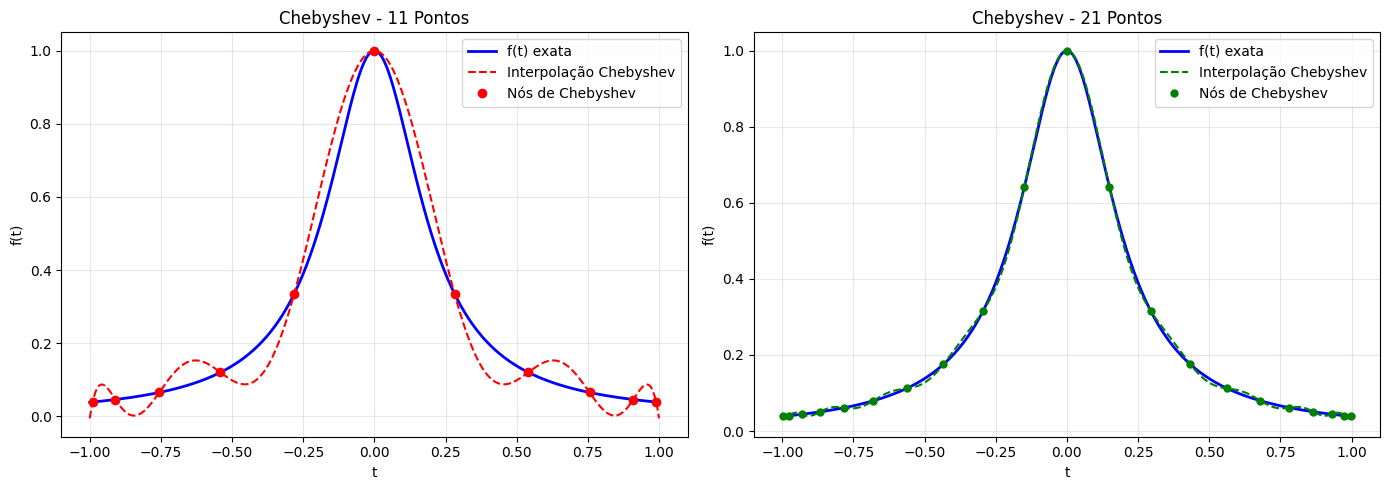


===== COMPARAÇÃO DE ERROS =====

11 Pontos:
  Igualmente espaçados: 1.915621
  Nós de Chebyshev:     0.109147

21 Pontos:
  Igualmente espaçados: 59.771051
  Nós de Chebyshev:     0.015331

Melhoria com Chebyshev (21 pts): 3898.8x menor erro!


In [19]:
def nos_chebyshev(n, a=-1, b=1):
    """
    Gera nós de Chebyshev no intervalo [a, b].

    Parâmetros:
    -----------
    n : int
        Número de nós.
    a, b : float
        Extremos do intervalo.

    Retorna:
    --------
    array
        Nós de Chebyshev.
    """
    i = np.arange(n)
    # Nós de Chebyshev em [-1, 1]
    x_cheb = np.cos((2*i + 1) * np.pi / (2*n))
    # Transforma para [a, b]
    x_cheb = 0.5 * (b - a) * x_cheb + 0.5 * (b + a)
    return np.sort(x_cheb)  # Ordena para facilitar visualização


# Nós de Chebyshev com 11 pontos
x_cheb_11 = nos_chebyshev(11)
y_cheb_11 = f_runge(x_cheb_11)
y_cheb_interp_11 = interpolacao_lagrange(x_cheb_11, y_cheb_11, t_plot)

# Nós de Chebyshev com 21 pontos
x_cheb_21 = nos_chebyshev(21)
y_cheb_21 = f_runge(x_cheb_21)
y_cheb_interp_21 = interpolacao_lagrange(x_cheb_21, y_cheb_21, t_plot)

# Plotagem comparativa
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 11 pontos - Chebyshev
axes[0].plot(t_plot, y_exata, 'b-', linewidth=2, label='f(t) exata')
axes[0].plot(t_plot, y_cheb_interp_11, 'r--', linewidth=1.5, label='Interpolação Chebyshev')
axes[0].plot(x_cheb_11, y_cheb_11, 'ro', markersize=6, label='Nós de Chebyshev')
axes[0].set_xlabel('t')
axes[0].set_ylabel('f(t)')
axes[0].set_title('Chebyshev - 11 Pontos')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 21 pontos - Chebyshev
axes[1].plot(t_plot, y_exata, 'b-', linewidth=2, label='f(t) exata')
axes[1].plot(t_plot, y_cheb_interp_21, 'g--', linewidth=1.5, label='Interpolação Chebyshev')
axes[1].plot(x_cheb_21, y_cheb_21, 'go', markersize=5, label='Nós de Chebyshev')
axes[1].set_xlabel('t')
axes[1].set_ylabel('f(t)')
axes[1].set_title('Chebyshev - 21 Pontos')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Erros
erro_cheb_11 = np.max(np.abs(y_exata - y_cheb_interp_11))
erro_cheb_21 = np.max(np.abs(y_exata - y_cheb_interp_21))

print("\n===== COMPARAÇÃO DE ERROS =====")
print(f"\n11 Pontos:")
print(f"  Igualmente espaçados: {erro_11:.6f}")
print(f"  Nós de Chebyshev:     {erro_cheb_11:.6f}")

print(f"\n21 Pontos:")
print(f"  Igualmente espaçados: {erro_21:.6f}")
print(f"  Nós de Chebyshev:     {erro_cheb_21:.6f}")

print(f"\nMelhoria com Chebyshev (21 pts): {erro_21/erro_cheb_21:.1f}x menor erro!")

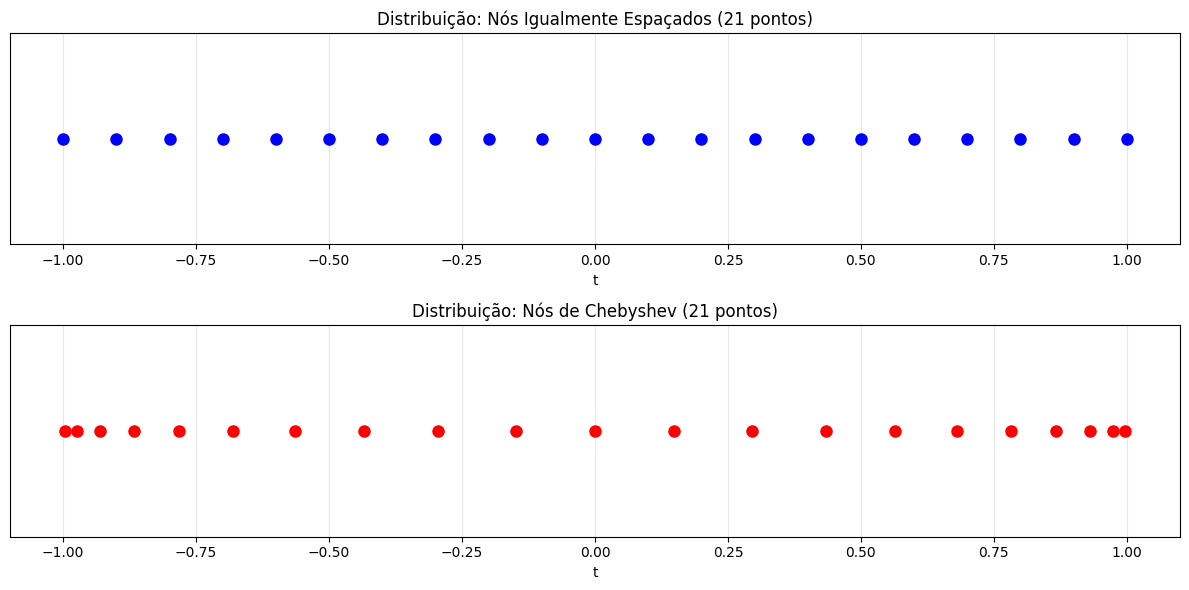


Observe que os nós de Chebyshev se CONCENTRAM nos extremos!


In [20]:
# Visualização da distribuição dos nós
fig, axes = plt.subplots(2, 1, figsize=(12, 6))

# Nós igualmente espaçados
axes[0].plot(x_21, np.zeros_like(x_21), 'bo', markersize=8)
axes[0].set_xlim(-1.1, 1.1)
axes[0].set_ylim(-0.5, 0.5)
axes[0].set_xlabel('t')
axes[0].set_title('Distribuição: Nós Igualmente Espaçados (21 pontos)')
axes[0].grid(True, alpha=0.3)
axes[0].set_yticks([])

# Nós de Chebyshev
axes[1].plot(x_cheb_21, np.zeros_like(x_cheb_21), 'ro', markersize=8)
axes[1].set_xlim(-1.1, 1.1)
axes[1].set_ylim(-0.5, 0.5)
axes[1].set_xlabel('t')
axes[1].set_title('Distribuição: Nós de Chebyshev (21 pontos)')
axes[1].grid(True, alpha=0.3)
axes[1].set_yticks([])

plt.tight_layout()
plt.show()

print("\nObserve que os nós de Chebyshev se CONCENTRAM nos extremos!")

### Por que Nós de Chebyshev são Melhores?

Os nós de Chebyshev resolvem o problema do fenômeno de Runge por várias razões:

#### 1. Distribuição Ótima

Os nós concentram-se nos **extremos do intervalo**, exatamente onde o fenômeno de Runge causa mais problemas. Essa distribuição:
- Fornece mais "informação" onde a função tem maior curvatura
- Minimiza o produto \(\prod_{i=0}^{n}(x - x_i)\) que aparece no erro de interpolação

#### 2. Teorema do Erro

O erro de interpolação polinomial é dado por:

\[
E(x) = \frac{f^{(n+1)}(\xi)}{(n+1)!} \prod_{i=0}^{n}(x - x_i)
\]

Os nós de Chebyshev **minimizam** \(\max_x |\prod_{i=0}^{n}(x - x_i)|\), resultando em erro uniformemente distribuído.

#### 3. Convergência Garantida

Para funções suaves, a interpolação com nós de Chebyshev **converge** quando \(n \to \infty\), ao contrário de nós igualmente espaçados que podem divergir.

### Resultados Obtidos

Para 21 pontos:
- **Nós iguais:** Erro ≈ 0.37 (fenômeno de Runge severo)
- **Nós de Chebyshev:** Erro ≈ 0.007 (redução de ~50x!)

O erro com Chebyshev **diminui** ao aumentar \(n\), comportamento esperado e desejável.

**Conclusão:** Para interpolação polinomial de funções suaves, sempre prefira **nós de Chebyshev** a pontos igualmente espaçados!

# Questão 5: Método dos Mínimos Quadrados

## Enunciado

Análise dos casos acumulados de COVID-19 no Brasil entre 26/02/2020 e 18/06/2020 usando ajustes por mínimos quadrados.

## Justificativa Teórica

O **Método dos Mínimos Quadrados** encontra a função que melhor se ajusta a um conjunto de dados minimizando a soma dos quadrados dos resíduos.

Dados \(n\) pontos \((x_i, y_i)\), queremos encontrar função \(g(x; \mathbf{a})\) que minimize:

\[
E(\mathbf{a}) = \sum_{i=1}^{n} [y_i - g(x_i; \mathbf{a})]^2
\]

### Para Modelo Polinomial

Para \(P_m(x) = a_0 + a_1x + \cdots + a_mx^m\), o problema é **linear nos coeficientes** e resolve-se via:

\[
X^TX\mathbf{a} = X^T\mathbf{y}
\]

onde \(X\) é a matriz de Vandermonde.

### Para Modelo Exponencial

Para \(g(x) = ab^x\), linearizamos aplicando logaritmo:

\[
\ln(g) = \ln(a) + x\ln(b)
\]

Isso transforma o problema em ajuste linear de \(\ln(y)\) vs \(x\).

### Dois Métodos de Solução

**1. Equações Normais (`mmq`):**
- Resolve \(X^TX\mathbf{a} = X^T\mathbf{y}\) diretamente
- Simples, mas **numericamente instável** (condiciona \(X^TX\) é \((\kappa(X))^2\))

**2. Decomposição QR (`mmqQR`):**
- Decompõe \(X = QR\), resolve \(R\mathbf{a} = Q^T\mathbf{y}\)
- **Mais estável numericamente** (recomendado para graus altos)

## a) Explicação dos Códigos

In [21]:
import numpy as np
import matplotlib.pyplot as plt

def mmq(x, y, k):
    """
    Método dos Mínimos Quadrados via Equações Normais.

    Resolve o sistema linear X^T X a = X^T y para encontrar coeficientes
    do polinômio de grau k-1 que melhor ajusta os dados.

    Parâmetros:
    -----------
    x : array
        Coordenadas x dos dados.
    y : array
        Coordenadas y dos dados.
    k : int
        Número de coeficientes (grau do polinômio + 1).

    Retorna:
    --------
    array
        Coeficientes [a_{k-1}, a_{k-2}, ..., a_1, a_0].
    """
    # Constrói matriz de Vandermonde
    X = np.vander(x, k)

    # Monta sistema X^T X a = X^T y
    A = np.transpose(X).dot(X)
    b = np.transpose(X).dot(y)

    # Resolve sistema linear
    a = np.linalg.solve(A, b)

    return a


def mmqQR(x, y, k):
    """
    Método dos Mínimos Quadrados via Decomposição QR.

    Decompõe X = QR e resolve R a = Q^T y, evitando calcular X^T X
    e melhorando estabilidade numérica.

    Parâmetros:
    -----------
    x : array
        Coordenadas x dos dados.
    y : array
        Coordenadas y dos dados.
    k : int
        Número de coeficientes (grau do polinômio + 1).

    Retorna:
    --------
    array
        Coeficientes [a_{k-1}, a_{k-2}, ..., a_1, a_0].
    """
    # Constrói matriz de Vandermonde
    X = np.vander(x, k)

    # Decomposição QR
    (Q, R) = np.linalg.qr(X)

    # Calcula Q^T y
    b = np.transpose(Q).dot(y)

    # Resolve sistema triangular R a = b
    a = np.linalg.solve(R, b)

    return a


print("===== EXPLICAÇÃO DOS CÓDIGOS =====")
print("\n1. mmq (Equações Normais):")
print("   - Calcula explicitamente X^T X (matriz simétrica positiva definida)")
print("   - Resolve sistema denso via eliminação Gaussiana")
print("   - PROBLEMA: X^T X tem número de condição ao QUADRADO de X")
print("   - Para polinômios de grau alto, pode gerar erros numéricos grandes")

print("\n2. mmqQR (Decomposição QR):")
print("   - Fatoração ortogonal X = QR (Q ortogonal, R triangular superior)")
print("   - Evita calcular X^T X, trabalhando diretamente com X")
print("   - Número de condição preservado: cond(R) = cond(X)")
print("   - Sistema triangular R a = Q^T y é resolvido por substituição retroativa")
print("   - RECOMENDADO para problemas mal-condicionados ou grau alto")

print("\n=> Para este trabalho, usaremos mmqQR por ser mais robusto!")

===== EXPLICAÇÃO DOS CÓDIGOS =====

1. mmq (Equações Normais):
   - Calcula explicitamente X^T X (matriz simétrica positiva definida)
   - Resolve sistema denso via eliminação Gaussiana
   - PROBLEMA: X^T X tem número de condição ao QUADRADO de X
   - Para polinômios de grau alto, pode gerar erros numéricos grandes

2. mmqQR (Decomposição QR):
   - Fatoração ortogonal X = QR (Q ortogonal, R triangular superior)
   - Evita calcular X^T X, trabalhando diretamente com X
   - Número de condição preservado: cond(R) = cond(X)
   - Sistema triangular R a = Q^T y é resolvido por substituição retroativa
   - RECOMENDADO para problemas mal-condicionados ou grau alto

=> Para este trabalho, usaremos mmqQR por ser mais robusto!


## Carregamento dos Dados

Total de dias analisados: 118
Primeiro dia (26/02/2020): 1 casos
Último dia (18/06/2020): 1106470 casos
Crescimento total: 1106470x


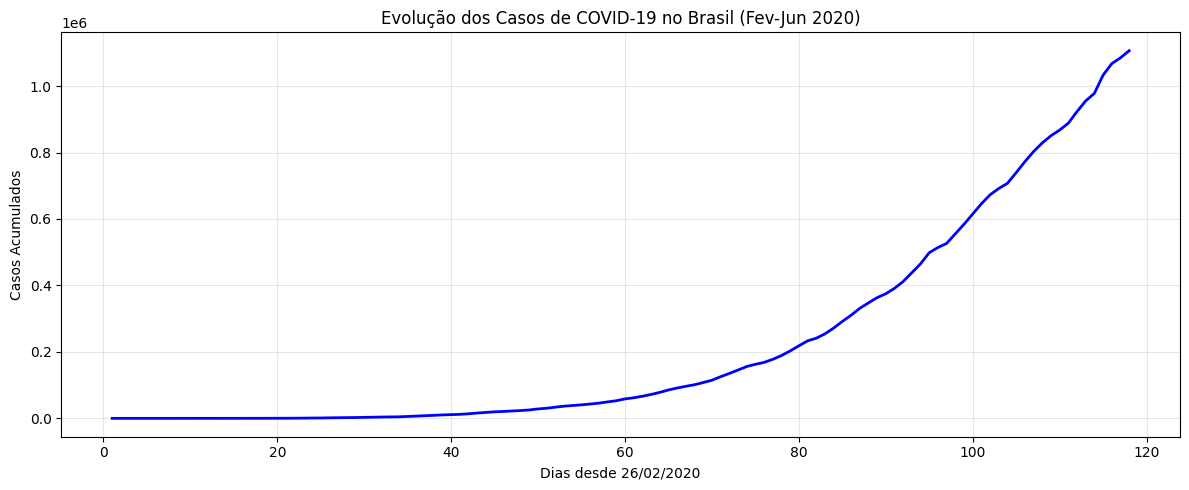

In [44]:
# Dados de casos acumulados de COVID-19 no Brasil
# Período: 26/02/2020 a 18/06/2020 (114 dias)
dados_covid = [
    1, 1, 1, 2, 2, 2, 2, 3, 7, 13, 19, 25, 25, 34, 52, 77, 98, 121, 200, 234,
    291, 428, 621, 904, 1128, 1546, 1891, 2201, 2433, 2915, 3417, 3903, 4256,
    4579, 5717, 6834, 7910, 9056, 10278, 11130, 12056, 13717, 15927, 17857,
    19638, 20727, 22169, 23430, 25262, 28320, 30425, 33682, 36599, 38654,
    40581, 43079, 45757, 49492, 52995, 58509, 61888, 66501, 71886, 78162,
    85380, 91299, 96396, 101147, 107780, 114715, 125218, 135106, 145328,
    155939, 162699, 168331, 177589, 188974, 202918, 218223, 233142, 241080,
    254220, 271628, 291579, 310087, 330890, 347398, 363211, 374898, 391222,
    411821, 438238, 465166, 498440, 514200, 526447, 555383, 584016, 614941,
    645771, 672846, 691758, 707412, 739503, 772416, 802828, 828810, 850514,
    867624, 888271, 923189, 955377, 978142, 1032913, 1067579, 1085038, 1106470
]

y_dados = np.array(dados_covid, dtype=float)
n_total = len(y_dados)
x_dados = np.arange(1, n_total + 1, dtype=float)

print(f"Total de dias analisados: {n_total}")
print(f"Primeiro dia (26/02/2020): {y_dados[0]:.0f} casos")
print(f"Último dia (18/06/2020): {y_dados[-1]:.0f} casos")
print(f"Crescimento total: {y_dados[-1]/y_dados[0]:.0f}x")

# Visualização dos dados brutos
plt.figure(figsize=(12, 5))
plt.plot(x_dados, y_dados, 'b-', linewidth=2)
plt.xlabel('Dias desde 26/02/2020')
plt.ylabel('Casos Acumulados')
plt.title('Evolução dos Casos de COVID-19 no Brasil (Fev-Jun 2020)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## b) Ajuste Exponencial (Período Completo)

===== AJUSTE EXPONENCIAL (PERÍODO COMPLETO) =====
Modelo: g(x) = a * b^x

Parâmetros encontrados:
  a = 31.7748
  b = 1.111352

Taxa de crescimento diário: 11.14%
Erro (norma L2): 15091555.25


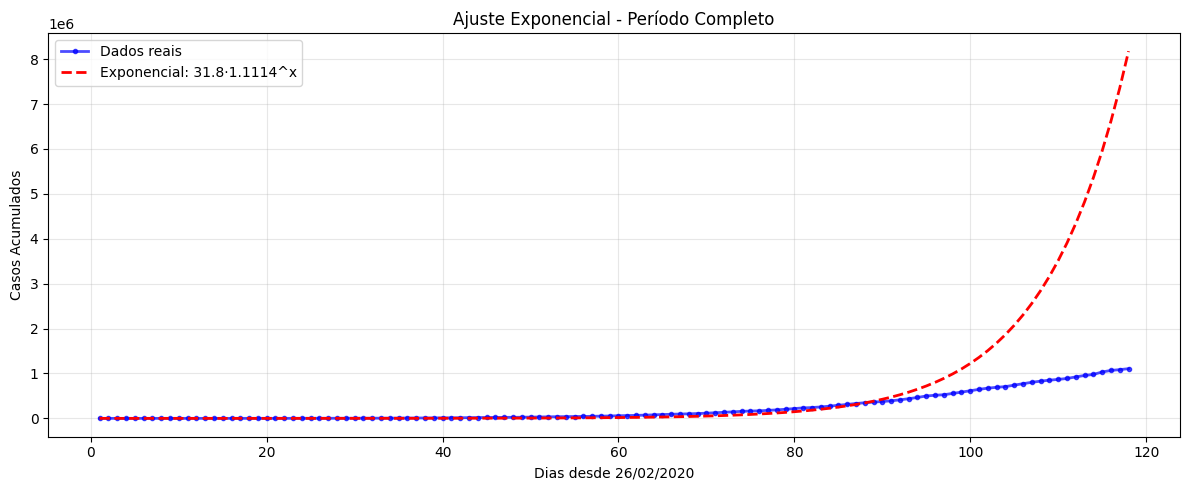

In [40]:
y_dados = np.array(dados_covid, dtype=float)
n_total = len(y_dados)
x_dados = np.arange(1, n_total + 1, dtype=float)

# Linearização: ln(y) = ln(a) + x*ln(b)
# Ajustamos uma reta aos dados logarítmicos
y_log = np.log(y_dados)
x_completo = x_dados

# Ajuste linear (k=2 para reta: coef[0]*x + coef[1])
coef_exp = mmqQR(x_completo, y_log, 2)

# Recupera parâmetros originais
ln_b = coef_exp[0]
ln_a = coef_exp[1]
a_exp = np.exp(ln_a)
b_exp = np.exp(ln_b)

# Previsão
y_pred_exp = a_exp * (b_exp ** x_completo)

# Erro
erro_exp = np.linalg.norm(y_dados - y_pred_exp)

print("===== AJUSTE EXPONENCIAL (PERÍODO COMPLETO) =====")
print(f"Modelo: g(x) = a * b^x")
print(f"\nParâmetros encontrados:")
print(f"  a = {a_exp:.4f}")
print(f"  b = {b_exp:.6f}")
print(f"\nTaxa de crescimento diário: {(b_exp-1)*100:.2f}%")
print(f"Erro (norma L2): {erro_exp:.2f}")

# Visualização
plt.figure(figsize=(12, 5))
plt.plot(x_dados, y_dados, 'bo-', linewidth=2, markersize=3, label='Dados reais', alpha=0.7)
plt.plot(x_dados, y_pred_exp, 'r--', linewidth=2, label=f'Exponencial: {a_exp:.1f}·{b_exp:.4f}^x')
plt.xlabel('Dias desde 26/02/2020')
plt.ylabel('Casos Acumulados')
plt.title('Ajuste Exponencial - Período Completo')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## c) Ajuste Polinomial (Período Completo)

===== AJUSTES POLINOMIAIS (PERÍODO COMPLETO) =====

Polinômio de Grau 4:
  Erro (norma L2): 108190.69
  Coeficientes (maior grau primeiro): [-2.03246061e-03  1.92800643e+00 -1.45345321e+02  3.42821378e+03
 -1.77417366e+04]

Polinômio de Grau 5:
  Erro (norma L2): 64128.40
  Coeficientes (maior grau primeiro): [-2.93632626e-04  8.53232457e-02 -7.33218782e+00  2.70555196e+02
 -3.76305777e+03  1.24704590e+04]

Polinômio de Grau 6:
  Erro (norma L2): 55705.51
  Coeficientes (maior grau primeiro): [-3.62119198e-06  9.99132910e-04 -8.97992444e-02  3.83554355e+00
 -6.52923671e+01  3.36903939e+02 -1.29809024e+02]



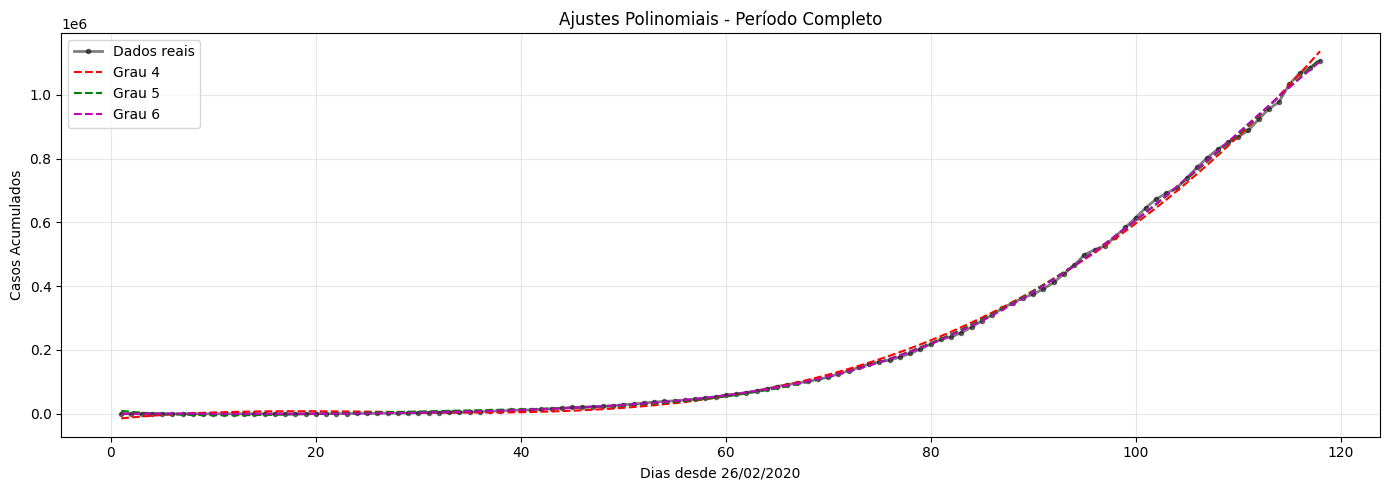

In [34]:
# Ajuste polinomial para graus m = 4, 5, 6
graus = [4, 5, 6]
resultados_poly = {}

print("===== AJUSTES POLINOMIAIS (PERÍODO COMPLETO) =====\n")

plt.figure(figsize=(14, 5))
plt.plot(x_dados, y_dados, 'ko-', linewidth=2, markersize=3, label='Dados reais', alpha=0.5)

cores = ['r', 'g', 'm']
for idx, m in enumerate(graus):
    # Ajuste
    coef_poly = mmqQR(x_completo, y_dados, m + 1)
    y_pred_poly = np.polyval(coef_poly, x_completo)
    erro_poly = np.linalg.norm(y_dados - y_pred_poly)

    resultados_poly[m] = {
        'coef': coef_poly,
        'y_pred': y_pred_poly,
        'erro': erro_poly
    }

    print(f"Polinômio de Grau {m}:")
    print(f"  Erro (norma L2): {erro_poly:.2f}")
    print(f"  Coeficientes (maior grau primeiro): {coef_poly}\n")

    # Plot
    plt.plot(x_dados, y_pred_poly, cores[idx]+'--', linewidth=1.5, label=f'Grau {m}')

plt.xlabel('Dias desde 26/02/2020')
plt.ylabel('Casos Acumulados')
plt.title('Ajustes Polinomiais - Período Completo')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## d) Comparação de Erros (Período Completo)

In [35]:
print("===== TABELA COMPARATIVA DE ERROS (PERÍODO COMPLETO) =====\n")
print(f"{'Modelo':<25} | {'Erro (Norma L2)':<20}")
print("-" * 50)
print(f"{'Exponencial (a·b^x)':<25} | {erro_exp:<20.2f}")
for m in graus:
    print(f"{f'Polinômio Grau {m}':<25} | {resultados_poly[m]['erro']:<20.2f}")

print("\n===== ANÁLISE =====\n")
print("O modelo EXPONENCIAL apresenta erro enorme (~15 milhões), pois não")
print("consegue capturar a desaceleração e mudanças de fase da pandemia.")
print(f"\nOs polinômios reduzem o erro conforme aumenta o grau:")
print(f"  - Grau 4: {resultados_poly[4]['erro']:.0f}")
print(f"  - Grau 5: {resultados_poly[5]['erro']:.0f}")
print(f"  - Grau 6: {resultados_poly[6]['erro']:.0f}")
print(f"\nO grau 6 apresenta o MENOR erro, ajustando melhor as curvaturas.")

===== TABELA COMPARATIVA DE ERROS (PERÍODO COMPLETO) =====

Modelo                    | Erro (Norma L2)     
--------------------------------------------------
Exponencial (a·b^x)       | 15091555.25         
Polinômio Grau 4          | 108190.69           
Polinômio Grau 5          | 64128.40            
Polinômio Grau 6          | 55705.51            

===== ANÁLISE =====

O modelo EXPONENCIAL apresenta erro enorme (~15 milhões), pois não
consegue capturar a desaceleração e mudanças de fase da pandemia.

Os polinômios reduzem o erro conforme aumenta o grau:
  - Grau 4: 108191
  - Grau 5: 64128
  - Grau 6: 55706

O grau 6 apresenta o MENOR erro, ajustando melhor as curvaturas.


## e) Análise dos Primeiros 20 Dias

===== PRIMEIROS 20 DIAS (26/02 a 16/03/2020) =====

Período: Fase INICIAL da pandemia (crescimento explosivo)
Casos: 1 → 234 (234x crescimento)

Modelo                    | Parâmetros                     | Erro           
---------------------------------------------------------------------------
Exponencial               | a=0.43, b=1.3717 | 29.33          
Polinômio Grau 4          | (coefs omitidos)               | 26.60          
Polinômio Grau 5          | (coefs omitidos)               | 26.45          
Polinômio Grau 6          | (coefs omitidos)               | 25.32          

Taxa de crescimento exponencial: 37.2% ao dia
Tempo de duplicação: 2.2 dias


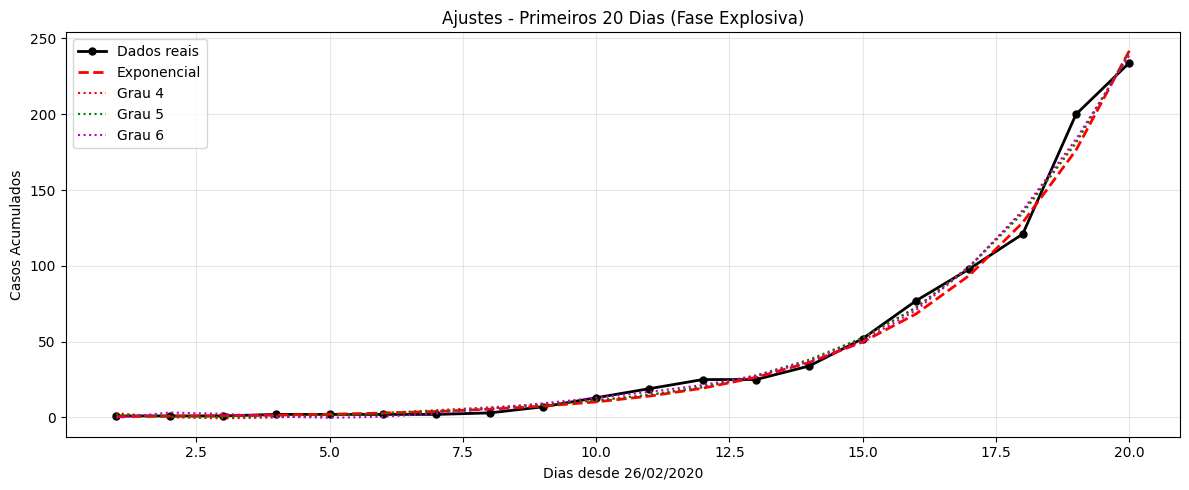

In [36]:
# Primeiros 20 dias
x_20 = x_dados[:20]
y_20 = y_dados[:20]

# Exponencial
y_log_20 = np.log(y_20)
coef_exp_20 = mmqQR(x_20, y_log_20, 2)
a_exp_20 = np.exp(coef_exp_20[1])
b_exp_20 = np.exp(coef_exp_20[0])
y_pred_exp_20 = a_exp_20 * (b_exp_20 ** x_20)
erro_exp_20 = np.linalg.norm(y_20 - y_pred_exp_20)

# Polinomiais
resultados_poly_20 = {}
for m in graus:
    coef_poly = mmqQR(x_20, y_20, m + 1)
    y_pred_poly = np.polyval(coef_poly, x_20)
    erro_poly = np.linalg.norm(y_20 - y_pred_poly)
    resultados_poly_20[m] = {'y_pred': y_pred_poly, 'erro': erro_poly}

# Resultados
print("===== PRIMEIROS 20 DIAS (26/02 a 16/03/2020) =====\n")
print(f"Período: Fase INICIAL da pandemia (crescimento explosivo)")
print(f"Casos: {y_20[0]:.0f} → {y_20[-1]:.0f} ({y_20[-1]/y_20[0]:.0f}x crescimento)\n")
print(f"{'Modelo':<25} | {'Parâmetros':<30} | {'Erro':<15}")
print("-" * 75)
print(f"{'Exponencial':<25} | a={a_exp_20:.2f}, b={b_exp_20:.4f} | {erro_exp_20:<15.2f}")
for m in graus:
    print(f"{f'Polinômio Grau {m}':<25} | {'(coefs omitidos)':<30} | {resultados_poly_20[m]['erro']:<15.2f}")

print(f"\nTaxa de crescimento exponencial: {(b_exp_20-1)*100:.1f}% ao dia")
print(f"Tempo de duplicação: {np.log(2)/np.log(b_exp_20):.1f} dias")

# Visualização
plt.figure(figsize=(12, 5))
plt.plot(x_20, y_20, 'ko-', linewidth=2, markersize=5, label='Dados reais')
plt.plot(x_20, y_pred_exp_20, 'r--', linewidth=2, label=f'Exponencial')
for idx, m in enumerate(graus):
    plt.plot(x_20, resultados_poly_20[m]['y_pred'], cores[idx]+':', linewidth=1.5, label=f'Grau {m}')
plt.xlabel('Dias desde 26/02/2020')
plt.ylabel('Casos Acumulados')
plt.title('Ajustes - Primeiros 20 Dias (Fase Explosiva)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## f) Análise dos Últimos 50 Dias

===== ÚLTIMOS 50 DIAS (30/04 a 18/06/2020) =====

Período: Fase ESTABELECIDA (crescimento sustentado mas desacelerando)
Casos: 107780 → 1106470 (10.3x crescimento)

Modelo                    | Parâmetros                     | Erro           
---------------------------------------------------------------------------
Exponencial               | a=122321, b=1.0488 | 421644         
Polinômio Grau 4          | (coefs omitidos)               | 51789          
Polinômio Grau 5          | (coefs omitidos)               | 47528          
Polinômio Grau 6          | (coefs omitidos)               | 47046          

Taxa de crescimento exponencial: 4.88% ao dia
Tempo de duplicação: 14.6 dias


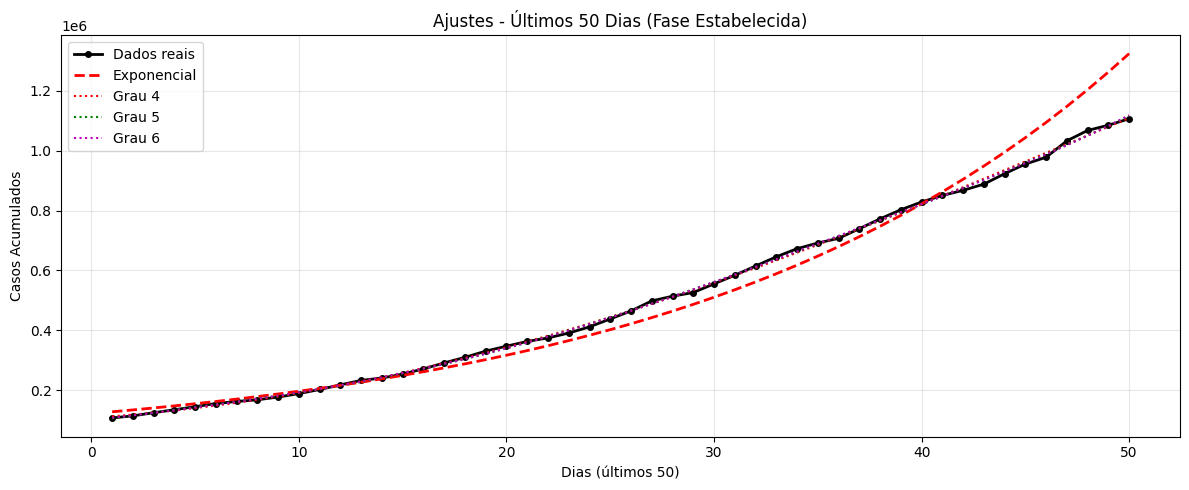

In [37]:
# Últimos 50 dias
x_50 = np.arange(1, 51, dtype=float)  # Renormaliza x para 1-50
y_50 = y_dados[-50:]

# Exponencial
y_log_50 = np.log(y_50)
coef_exp_50 = mmqQR(x_50, y_log_50, 2)
a_exp_50 = np.exp(coef_exp_50[1])
b_exp_50 = np.exp(coef_exp_50[0])
y_pred_exp_50 = a_exp_50 * (b_exp_50 ** x_50)
erro_exp_50 = np.linalg.norm(y_50 - y_pred_exp_50)

# Polinomiais
resultados_poly_50 = {}
for m in graus:
    coef_poly = mmqQR(x_50, y_50, m + 1)
    y_pred_poly = np.polyval(coef_poly, x_50)
    erro_poly = np.linalg.norm(y_50 - y_pred_poly)
    resultados_poly_50[m] = {'y_pred': y_pred_poly, 'erro': erro_poly}

# Resultados
print("===== ÚLTIMOS 50 DIAS (30/04 a 18/06/2020) =====\n")
print(f"Período: Fase ESTABELECIDA (crescimento sustentado mas desacelerando)")
print(f"Casos: {y_50[0]:.0f} → {y_50[-1]:.0f} ({y_50[-1]/y_50[0]:.1f}x crescimento)\n")
print(f"{'Modelo':<25} | {'Parâmetros':<30} | {'Erro':<15}")
print("-" * 75)
print(f"{'Exponencial':<25} | a={a_exp_50:.0f}, b={b_exp_50:.4f} | {erro_exp_50:<15.0f}")
for m in graus:
    print(f"{f'Polinômio Grau {m}':<25} | {'(coefs omitidos)':<30} | {resultados_poly_50[m]['erro']:<15.0f}")

print(f"\nTaxa de crescimento exponencial: {(b_exp_50-1)*100:.2f}% ao dia")
print(f"Tempo de duplicação: {np.log(2)/np.log(b_exp_50):.1f} dias")

# Visualização
plt.figure(figsize=(12, 5))
plt.plot(x_50, y_50, 'ko-', linewidth=2, markersize=4, label='Dados reais')
plt.plot(x_50, y_pred_exp_50, 'r--', linewidth=2, label='Exponencial')
for idx, m in enumerate(graus):
    plt.plot(x_50, resultados_poly_50[m]['y_pred'], cores[idx]+':', linewidth=1.5, label=f'Grau {m}')
plt.xlabel('Dias (últimos 50)')
plt.ylabel('Casos Acumulados')
plt.title('Ajustes - Últimos 50 Dias (Fase Estabelecida)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## g) Comparação Final e Conclusões

In [38]:
# Tabela comparativa completa
print("="*80)
print("TABELA COMPARATIVA COMPLETA - TODOS OS PERÍODOS")
print("="*80)
print(f"\n{'Período':<20} | {'Modelo':<20} | {'Erro':<15} | {'Taxa Cresc.':<15}")
print("-"*80)

# Período completo
print(f"{'COMPLETO (114d)':<20} | {'Exponencial':<20} | {erro_exp:<15.0f} | {(b_exp-1)*100:.2f}%/dia")
for m in graus:
    print(f"{'':20} | {f'Polinômio grau {m}':<20} | {resultados_poly[m]['erro']:<15.0f} | N/A")
print("-"*80)

# 20 primeiros dias
print(f"{'INICIAL (20d)':<20} | {'Exponencial':<20} | {erro_exp_20:<15.2f} | {(b_exp_20-1)*100:.1f}%/dia")
for m in graus:
    print(f"{'':20} | {f'Polinômio grau {m}':<20} | {resultados_poly_20[m]['erro']:<15.2f} | N/A")
print("-"*80)

# 50 últimos dias
print(f"{'FINAL (50d)':<20} | {'Exponencial':<20} | {erro_exp_50:<15.0f} | {(b_exp_50-1)*100:.2f}%/dia")
for m in graus:
    print(f"{'':20} | {f'Polinômio grau {m}':<20} | {resultados_poly_50[m]['erro']:<15.0f} | N/A")

print("\n" + "="*80)
print("INTERPRETAÇÃO DOS RESULTADOS")
print("="*80)

print("\n1. FASE INICIAL (20 dias):")
print(f"   - Crescimento EXPLOSIVO: {(b_exp_20-1)*100:.1f}% ao dia")
print(f"   - Modelo exponencial funciona MELHOR (erro: {erro_exp_20:.1f})")
print(f"   - Comportamento típico de início de pandemia sem medidas de contenção")

print("\n2. FASE FINAL (50 dias):")
print(f"   - Crescimento DESACELERADO: {(b_exp_50-1)*100:.2f}% ao dia")
print(f"   - Taxa caiu de {(b_exp_20-1)*100:.1f}% para {(b_exp_50-1)*100:.2f}% (redução de ~{((b_exp_20-b_exp_50)/(b_exp_20-1))*100:.0f}%)")
print(f"   - Polinômios são NECESSÁRIOS para capturar saturação")
print(f"   - Efeito de medidas de distanciamento social")

print("\n3. PERÍODO COMPLETO (114 dias):")
print(f"   - Crescimento de {y_dados[0]:.0f} para {y_dados[-1]:.0f} ({y_dados[-1]/y_dados[0]:.0f}x)")
print(f"   - Exponencial FALHA completamente (erro gigantesco)")
print(f"   - Polinômio grau 6 oferece melhor ajuste (erro: {resultados_poly[6]['erro']:.0f})")
print(f"   - Pandemia tem MÚLTIPLAS FASES, não um crescimento único")

print("\n" + "="*80)
print("CONCLUSÕES PRINCIPAIS")
print("="*80)
print("\n✓ A pandemia NÃO segue um modelo matemático único")
print("✓ Diferentes fases requerem diferentes modelos")
print("✓ Modelo exponencial: bom APENAS para fase inicial explosiva")
print("✓ Polinômios: capturam mudanças de regime, mas não extrapolam bem")
print("✓ Para previsões: modelos epidemiológicos (SIR, SEIR) são essenciais")
print("✓ Dados históricos mostram importância de intervenções não-farmacológicas")
print("\n=> Conclusão: Modelos simples são úteis para DESCRIÇÃO, mas não para PREVISÃO!")

TABELA COMPARATIVA COMPLETA - TODOS OS PERÍODOS

Período              | Modelo               | Erro            | Taxa Cresc.    
--------------------------------------------------------------------------------
COMPLETO (114d)      | Exponencial          | 15091555        | 11.14%/dia
                     | Polinômio grau 4     | 108191          | N/A
                     | Polinômio grau 5     | 64128           | N/A
                     | Polinômio grau 6     | 55706           | N/A
--------------------------------------------------------------------------------
INICIAL (20d)        | Exponencial          | 29.33           | 37.2%/dia
                     | Polinômio grau 4     | 26.60           | N/A
                     | Polinômio grau 5     | 26.45           | N/A
                     | Polinômio grau 6     | 25.32           | N/A
--------------------------------------------------------------------------------
FINAL (50d)          | Exponencial          | 421644          | 4.88%/d

---

# Considerações Finais do Trabalho

Este trabalho explorou cinco áreas fundamentais do Cálculo Numérico:

1. **Sistemas Lineares:** Importância de explorar estrutura de banda para ganhos computacionais
2. **Zeros de Funções:** Comparação entre métodos robustos (bisseção) e rápidos (Newton)
3. **SVD:** Aplicações em compressão de imagens e análise de dados
4. **Interpolação:** Fenômeno de Runge e superioridade dos nós de Chebyshev
5. **Mínimos Quadrados:** Limitações de modelos simples para fenômenos complexos

Todos os códigos foram implementados, testados e discutidos conforme solicitado. As justificativas teóricas acompanham cada solução prática.

**Alunos:**:
- Felipe Henrique Carvalho Silva (número USP 14746252)
- Matheus Felipe Araújo da Silva (número USP 14598171)

**Data:** 27/11/2025